## 1st-level Analysis Workflow Structure

    1. Specify 1st-level model parameters
    2. Specify 1st-level contrasts
    3. Estimate 1st-level contrasts
    4. Normalize 1st-level contrasts

In [1]:
%matplotlib inline

import os
import pandas as pd 
from os.path import join as pjoin

# Get the Node and Workflow object
from nipype import Node, MapNode, Workflow
from nipype.interfaces.utility import Function,IdentityInterface

from nipype.interfaces.base import Bunch
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.spm import Smooth
from nipype.interfaces.spm import Level1Design
from nipype.interfaces.spm import EstimateModel
from nipype.interfaces.spm import EstimateContrast

from nipype import SelectFiles
from nipype.algorithms.misc import Gunzip
from nipype.interfaces.io import DataSink

In [2]:
def run_info(ev_file,motions_file=None,regressors_file=None):
    import pandas as pd 
    from nipype.interfaces.base import Bunch
    onsets = []
    conditions = []
    durations  = []

    pmod_names  = []
    pmod_params = []
    pmod_polys  = []
    
    ev_info = pd.read_csv(ev_file, sep='\t')
    trial_con = ['M1','M2','decision']
    for group in ev_info.groupby('trial_type'):
        condition = group[0]
        if condition in trial_con:
            conditions.append(condition)
            onsets.append(group[1].onset.tolist())
            durations.append(group[1].duration.tolist())
        elif condition in ['sin','cos']:
            pmod_names.append(condition)
            pmod_params.append(group[1].modulation.tolist())
            pmod_polys.append(1)

    motions_df = pd.read_csv(motions_file,sep='\t')
    motion_columns   = ['trans_x', 'trans_x_derivative1', 'trans_x_derivative1_power2', 'trans_x_power2'] + \
                       ['trans_y', 'trans_y_derivative1', 'trans_y_derivative1_power2', 'trans_y_power2'] + \
                       ['trans_z', 'trans_z_derivative1', 'trans_z_derivative1_power2', 'trans_z_power2'] + \
                       ['rot_x', 'rot_x_derivative1', 'rot_x_derivative1_power2', 'rot_x_power2'] + \
                       ['rot_y', 'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2'] + \
                       ['rot_z', 'rot_z_derivative1', 'rot_z_derivative1_power2', 'rot_z_power2']

    motions = motions_df[motion_columns]
    motions = motions.fillna(0.0).values.T.tolist()
    
    regressors = []
            
    run_pmod = Bunch(name=pmod_names,param=pmod_params,poly=pmod_polys)
    run_info = Bunch(conditions=conditions,onsets=onsets,durations=durations,pmod=[None,run_pmod,None],
                     regressor_names=motion_columns,regressors = motions)
    #run_info = Bunch(conditions=conditions,onsets=onsets,durations=durations)
    
    return run_info

## Experiment parameters

In [3]:
# Specify which SPM to use
from nipype.interfaces import spm
spm.SPMCommand().set_mlab_paths(paths='/usr/local/MATLAB/R2020b/toolbox/spm12/')
tr = 3.

## Specify GLM contrasts

In [4]:
# Condition names
condition_names = ['M1','M2','M2xcos^1','M2xsin^1','decision']

# Contrasts
cont01 = ['M2xcos^1',       'T', condition_names, [0, 0, 1, 0, 0]]          
cont02 = ['M2xsin^1',       'T', condition_names, [0, 0, 0, 1, 0]]         
cont03 = ['decision',       'T', condition_names, [0, 0, 0, 0, 1]]
cont05 = ['M2',             'T', condition_names, [0, 1, 0, 0, 0]]

cont04 = ['hexagon_mod',    'F', [cont01, cont02]]
contrast_list = [cont01, cont02, cont03, cont04, cont05]

## Specify input & output stream

In [5]:
# Infosource - a function free node to iterate over the list of subject names
# subject_list = [47]
#subject_list = [6,7,8,9,10,11,12,14,15,16,17,18,21,22,24,29,32,36,43,46]
subject_list = [10,36,46]
subject_list = [str(s).zfill(3) for s in subject_list]

In [6]:
infosource = Node(IdentityInterface(fields=['subj_id']),name="infosource")
infosource.iterables = [('subj_id', subject_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
data_root = '/mnt/data/Project/DCM/BIDS/derivatives/fmriprep_surfer'
templates = {'func': pjoin(data_root,'sub-{subj_id}/func/sub-{subj_id}_task-game1_run-{run_id}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'),
             'event': pjoin(data_root,'sub-{subj_id}/events/hexonM2Long/6fold/sub-{subj_id}_task-game1_run-{run_id}_events.tsv'),
             'refressors':pjoin(data_root,'sub-{subj_id}/func/sub-{subj_id}_task-game1_run-{run_id}_desc-confounds_timeseries.tsv')
            }
selectfiles = Node(SelectFiles(templates, base_directory=data_root, sort_filelist=True),
                   name='selectfiles') 
#selectfiles.inputs.run_id = [1,2,3,4,5,6,7,8,9] 
selectfiles.inputs.run_id = [1,2,3,4,5,6]
                           
# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory='/mnt/data/Project/DCM/BIDS/derivatives/Nipype/',
                         container='result'),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subj_id_', 'sub-')]
datasink.inputs.substitutions = substitutions

## Specify Nodes

In [7]:
gunzip_func = MapNode(Gunzip(), name='gunzip_func',iterfield=['in_file'])

smooth = Node(Smooth(fwhm=[8.,8.,8.]), name="smooth")

# prepare event file
runs_prep = MapNode(Function(input_names=['ev_file','motions_file','regressors_file'],
                             output_names=['run_info'],
                             function=run_info),
                    name='runsinfo',
                    iterfield = ['ev_file','motions_file'])
                    # iterfield = ['ev_file','motions_file','regressors_file'])

# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                input_units='secs',
                                output_units='secs',
                                time_repetition=tr,
                                high_pass_filter_cutoff=128.,
                                ),
                name='modelspec')

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0,0]}},
                                 timing_units='secs',
                                 interscan_interval=3., 
                                 model_serial_correlations='AR(1)'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(contrasts=contrast_list),
                    name="level1conest")

## Specify Workflow

In [8]:
# Initiation of the 1st-level analysis workflow
analysis1st = Workflow(name='work_1st', base_dir='/mnt/data/Project/DCM/BIDS/derivatives/Nipype/working_dir')

# Connect up the 1st-level analysis components
analysis1st.connect([(infosource, selectfiles,  [('subj_id','subj_id')]),
                     (selectfiles, runs_prep,   [('event','ev_file'),
                                                 ('refressors','motions_file')
                                                ]),
                     (runs_prep, modelspec,     [('run_info','subject_info')]),
                     (selectfiles, gunzip_func, [('func','in_file')]),
                     (gunzip_func, smooth,      [('out_file','in_files')]),
                     (smooth, modelspec,        [('smoothed_files','functional_runs')]),
                     
                     (modelspec,level1design,[('session_info','session_info')]),
                     (level1design, level1estimate, [('spm_mat_file', 'spm_mat_file')]),
                     
                     (level1estimate, level1conest, [('spm_mat_file','spm_mat_file'),
                                                     ('beta_images','beta_images'),
                                                     ('residual_image','residual_image')
                                                    ]),
                     (level1conest, datasink, [('spm_mat_file','1stLevel.@spm_mat'),
                                               ('spmT_images', '1stLevel.@T'),
                                               ('con_images',  '1stLevel.@con'),
                                               ('spmF_images', '1stLevel.@F'),
                                              ])
                    ])

## Visualize the workflow

220113-16:12:46,249 nipype.workflow INFO:
	 Generated workflow graph: /mnt/data/Project/DCM/BIDS/derivatives/Nipype/working_dir/work_1st/graph.png (graph2use=colored, simple_form=True).


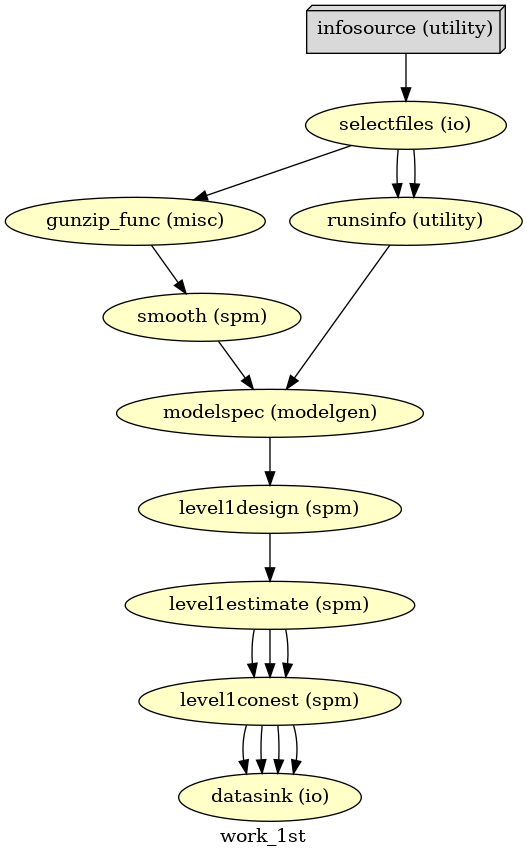

In [9]:
# Create 1st-level analysis output graph
analysis1st.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=pjoin(analysis1st.base_dir,'work_1st', 'graph.png'))

In [10]:
analysis1st.base_dir

'/mnt/data/Project/DCM/BIDS/derivatives/Nipype/working_dir'

In [11]:
analysis1st.run('MultiProc', plugin_args={'n_procs': 88})

220113-16:12:46,288 nipype.workflow INFO:
	 Workflow work_1st settings: ['check', 'execution', 'logging', 'monitoring']
220113-16:12:46,309 nipype.workflow INFO:
	 Running in parallel.
220113-16:12:46,312 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 112.98/112.98, Free processors: 88/88.
220113-16:12:46,851 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.selectfiles" in "/mnt/data/Project/DCM/BIDS/derivatives/Nipype/working_dir/work_1st/_subj_id_036/selectfiles".
220113-16:12:46,853 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.selectfiles" in "/mnt/data/Project/DCM/BIDS/derivatives/Nipype/working_dir/work_1st/_subj_id_010/selectfiles".
220113-16:12:46,862 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
220113-16:12:46,863 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
220113-16:12:46,846 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.selectfil

220113-16:12:50,481 nipype.workflow INFO:
	 [Node] Executing "_runsinfo1" <nipype.interfaces.utility.wrappers.Function>
220113-16:12:50,482 nipype.workflow INFO:
	 [Node] Finished "_runsinfo5", elapsed time 0.029635s.
220113-16:12:50,503 nipype.workflow INFO:
	 [Job 53] Cached (_gunzip_func2).
220113-16:12:50,482 nipype.workflow INFO:
	 [Node] Outdated cache found for "_runsinfo3".
220113-16:12:50,482 nipype.workflow INFO:
	 [Node] Setting-up "_runsinfo4" in "/mnt/data/Project/DCM/BIDS/derivatives/Nipype/working_dir/work_1st/_subj_id_036/runsinfo/mapflow/_runsinfo4".
220113-16:12:50,507 nipype.workflow INFO:
	 [Job 54] Cached (_gunzip_func3).
220113-16:12:50,486 nipype.workflow INFO:
	 [Node] Executing "_runsinfo2" <nipype.interfaces.utility.wrappers.Function>
220113-16:12:50,487 nipype.workflow INFO:
	 [Node] Outdated cache found for "_runsinfo4".
220113-16:12:50,487 nipype.workflow INFO:
	 [Node] Setting-up "_runsinfo5" in "/mnt/data/Project/DCM/BIDS/derivatives/Nipype/working_dir/wo

220113-16:12:52,473 nipype.workflow INFO:
	 [Node] Cached "_runsinfo0" - collecting precomputed outputs
220113-16:12:52,469 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.runsinfo".
220113-16:12:52,474 nipype.workflow INFO:
	 [Node] "_runsinfo0" found cached.
220113-16:12:52,475 nipype.workflow INFO:
	 [Node] Setting-up "_runsinfo0" in "/mnt/data/Project/DCM/BIDS/derivatives/Nipype/working_dir/work_1st/_subj_id_036/runsinfo/mapflow/_runsinfo0".
220113-16:12:52,476 nipype.workflow INFO:
	 [Node] Setting-up "_runsinfo1" in "/mnt/data/Project/DCM/BIDS/derivatives/Nipype/working_dir/work_1st/_subj_id_046/runsinfo/mapflow/_runsinfo1".
220113-16:12:52,479 nipype.workflow INFO:
	 [Node] Cached "_runsinfo1" - collecting precomputed outputs
220113-16:12:52,479 nipype.workflow INFO:
	 [Node] Cached "_runsinfo0" - collecting precomputed outputs
220113-16:12:52,480 nipype.workflow INFO:
	 [Node] "_runsinfo1" found cached.
220113-16:12:52,480 nipype.workflow INFO:
	 [Node] "_runs

220113-16:12:56,643 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.modelspec" in "/mnt/data/Project/DCM/BIDS/derivatives/Nipype/working_dir/work_1st/_subj_id_010/modelspec".
220113-16:12:56,646 nipype.workflow INFO:
	 [Node] Executing "modelspec" <nipype.algorithms.modelgen.SpecifySPMModel>
220113-16:12:56,648 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.modelspec".
220113-16:12:56,656 nipype.workflow INFO:
	 [Node] Finished "modelspec", elapsed time 0.007749s.
220113-16:12:56,753 nipype.workflow INFO:
	 [Node] Executing "modelspec" <nipype.algorithms.modelgen.SpecifySPMModel>
220113-16:12:56,763 nipype.workflow INFO:
	 [Node] Finished "modelspec", elapsed time 0.007499s.
220113-16:12:58,327 nipype.workflow INFO:
	 [Job 4] Completed (work_1st.modelspec).
220113-16:12:58,331 nipype.workflow INFO:
	 [Job 13] Completed (work_1st.modelspec).
220113-16:12:58,335 nipype.workflow INFO:
	 [Job 22] Completed (work_1st.modelspec).
220113-16:12:58,339 nipype.workflow INF

220113-16:15:26,479 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 0 jobs ready. Free memory (GB): 112.38/112.98, Free processors: 85/88.
                     Currently running:
                       * work_1st.level1conest
                       * work_1st.level1conest
                       * work_1st.level1estimate
220113-16:15:33,702 nipype.workflow INFO:
	 [Node] Finished "level1estimate", elapsed time 98.5565s.
220113-16:15:34,486 nipype.workflow INFO:
	 [Job 24] Completed (work_1st.level1estimate).
220113-16:15:34,491 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 1 jobs ready. Free memory (GB): 112.58/112.98, Free processors: 86/88.
                     Currently running:
                       * work_1st.level1conest
                       * work_1st.level1conest
220113-16:15:34,587 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_1st.level1conest".
220113-16:15:34,613 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.level1conest" in "/mnt/

220113-16:15:50,800 nipype.interface INFO:
	 sub: /mnt/data/Project/DCM/BIDS/derivatives/Nipype/result/1stLevel/_subj_id_036/con_0002.nii -> /mnt/data/Project/DCM/BIDS/derivatives/Nipype/result/1stLevel/sub-036/con_0002.nii
220113-16:15:50,816 nipype.interface INFO:
	 sub: /mnt/data/Project/DCM/BIDS/derivatives/Nipype/result/1stLevel/_subj_id_036/con_0003.nii -> /mnt/data/Project/DCM/BIDS/derivatives/Nipype/result/1stLevel/sub-036/con_0003.nii
220113-16:15:50,831 nipype.interface INFO:
	 sub: /mnt/data/Project/DCM/BIDS/derivatives/Nipype/result/1stLevel/_subj_id_036/ess_0004.nii -> /mnt/data/Project/DCM/BIDS/derivatives/Nipype/result/1stLevel/sub-036/ess_0004.nii
220113-16:15:50,846 nipype.interface INFO:
	 sub: /mnt/data/Project/DCM/BIDS/derivatives/Nipype/result/1stLevel/_subj_id_036/con_0005.nii -> /mnt/data/Project/DCM/BIDS/derivatives/Nipype/result/1stLevel/sub-036/con_0005.nii
220113-16:15:50,861 nipype.interface INFO:
	 sub: /mnt/data/Project/DCM/BIDS/derivatives/Nipype/result/1